In [ ]:
import warnings
warnings.filterwarnings("ignore")
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import torch
import torch.nn as nn
import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import torch.optim as optim


!pip install wandb
import wandb
wandb.login(key='fbf80504ccef17f5f3b05723be7ea4caff805164')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.9/264.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
#importing dataset from Kaggle

!pip install wget
import wget
wget.download('https://storage.googleapis.com/wandb_datasets/nature_12K.zip')
!unzip /content/nature_12K.zip
def load_data():
    trainset= "/content/inaturalist_12K/train"
    testset = "/content/inaturalist_12K/val"
    return trainset,testset


In [ ]:
class MyCNNModel(nn.Module):
    def __init__(self, num_filter=[64,64,64,64,64], filter_size=[3,3,3,3,3], cnn_act_fun='mish',batch_norm=True,dropout=0.1,dense_size=256,dense_act_fun='mish' ,mystride=2,img_len=224,img_wid=224):
        super(MyCNNModel,self).__init__()


        self.len=img_len
        self.wid=img_wid

        for i in range(5):
             self.len = (self.len - (filter_size[i] - 1)) // mystride#final length of the image
             self.wid = (self.wid - (filter_size[i] - 1)) // mystride#final width of the image


        self.cnn_act_fun=cnn_act_fun
        self.batch_norm=batch_norm
        self.dropout=dropout
        self.dense_size=dense_size
        self.dense_act_fun=dense_act_fun
        self.mystride=mystride

        act_fn = {'relu': nn.ReLU(),'gelu':nn.GELU(),'mish':nn.Mish(),'silu':nn.SiLU()}

        self.layers = nn.ModuleList([
            #first layer
            nn.Conv2d(in_channels=3, out_channels=num_filter[0], kernel_size=filter_size[0]),
            act_fn[self.cnn_act_fun],
            nn.BatchNorm2d(num_filter[0]) if self.batch_norm==True else nn.Identity() ,
            nn.MaxPool2d(kernel_size=2,stride=mystride),

            #second layer
            nn.Conv2d(num_filter[0], num_filter[1], filter_size[1]),
            act_fn[self.cnn_act_fun],
            nn.BatchNorm2d(num_filter[1]) if self.batch_norm==True else nn.Identity() ,
            nn.MaxPool2d(kernel_size=2,stride=mystride),

            #third layer
            nn.Conv2d(num_filter[1], num_filter[2], filter_size[2]),
            act_fn[self.cnn_act_fun] ,
            nn.BatchNorm2d(num_filter[2]) if self.batch_norm==True else nn.Identity() ,
            nn.MaxPool2d(kernel_size=2,stride=mystride),

            #fourth layer
            nn.Conv2d(num_filter[2], num_filter[3], filter_size[3]),
            act_fn[self.cnn_act_fun] ,
            nn.BatchNorm2d(num_filter[3]) if self.batch_norm==True else nn.Identity(),
            nn.MaxPool2d(kernel_size=2,stride=mystride),


            #fifth layer
            nn.Conv2d(num_filter[3], num_filter[4], filter_size[4]),
            act_fn[self.cnn_act_fun]  ,
            nn.BatchNorm2d(num_filter[4]) if self.batch_norm==True else nn.Identity(),
            nn.MaxPool2d(kernel_size=2,stride=mystride),

            #fully connected layer
            nn.Flatten(),
            nn.Linear(int(num_filter[4]*self.len*self.wid),dense_size),
            act_fn[self.cnn_act_fun],
            nn.Dropout(dropout),
            nn.Linear(dense_size,10)

        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [ ]:
#PyTorch can make use of GPUs to accelerate training and inference of deep learning models.
torch.cuda.device_count()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
#Evaluation function which give sus the accuracy and loss using cross entropy loss
def evaluation(dataloader ,net,loss_fn ):
    total, correct = 0, 0
    loss_epoch_arr = []
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss_epoch_arr.append(loss.item())
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()

    return 100 * correct / total,sum(loss_epoch_arr)/len(loss_epoch_arr)

In [ ]:
def main(num_filter=[64,64,64,64,64], filter_size=[3,3,3,3,3], cnn_act_fun='mish',data_aug=True,batch_norm=True,dropout=0.1,dense_size=256,dense_act_fun='mish' ,mystride=2,max_epochs=10):

    trainset,testset=load_data()



    #my transformation on the trainset
    transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.CenterCrop((224,224)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ])

    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])


    #considering data augmentation
    if data_aug:
        trainset = datasets.ImageFolder(trainset,transform_train)
        testset = datasets.ImageFolder(testset,transform)
    else:
        trainset = datasets.ImageFolder(trainset,transform)
        testset = datasets.ImageFolder(testset,transform)

    n_val = int(np.floor(0.2 * len(trainset)))
    n_train = len(trainset) - n_val
    trainset,evalset=random_split(trainset,[n_train,n_val])
    testset,testset2=random_split(testset,[len(testset),0])


    batch_size = 32  #you better know the importamce of batchsize especially with respect to GPU memory
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    net = MyCNNModel().to(device)
    loss_fn = nn.CrossEntropyLoss()
    opt = optim.Adamax(net.parameters(),lr=1e-4)


    for epoch in range(max_epochs):
        loss_epoch_arr = []
        for i, data in enumerate(trainloader, 0):
            if i%50==0:
                print("epoch  ",epoch,"batch  ",i)

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            opt.zero_grad()

            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            loss_epoch_arr.append(loss.item())

        loss_train=sum(loss_epoch_arr)/len(loss_epoch_arr)
        train_acc,_=evaluation(trainloader,net,loss_fn)
        eval_acc,loss_eval=evaluation(evalloader,net,loss_fn)
        print(f'train loss:- {loss_train} train acc:- {train_acc} val loss:- {loss_eval} val acc:- {eval_acc} ')
        wandb.log({'train loss':loss_train,'train acc':train_acc, 'val loss':loss_eval,'val acc':eval_acc})



In [ ]:
sweep_config={

  "method": "bayes",
  "metric": {
      "name": "val acc",
      "goal": "maximize"
    },
  "parameters": {
        "max_epochs": {
            "values": [5,7,9]
        },
        "num_filter":{
            "values":[[64,64,64,64,64],[32,64,128,256,512],[32,32,32,32,32],[512,256,128,64,32]]
        },
        "filter_size":{
            "values":[[3,3,3,3,3],[5,5,5,5,5],[11,9,7,5,3]]
        },
        "cnn_act_fun":{
            "values":['relu','gelu','mish','silu']
        },
        "data_aug":{
            "values":[True,False]
        },
        "batch_norm": {
            "values": [True,False]
        },
        "dense_act_fun":{
            "values":['relu','gelu','mish','silu']
        },
        "dropout":{
            "values":[0.1,0.2,0.3]
        },
        "dense_size":{
            "values":[128,256,512]
        },
        "mystride":{
            "values":[2,3,5]
        }
    }
}

In [ ]:
def train():
    wandb.init()
    config=wandb.config
    max_epochs=config.max_epochs
    num_filter=config.num_filter
    filter_size=config.filter_size
    cnn_act_fun=config.cnn_act_fun
    data_aug=config.data_aug
    batch_norm=config.batch_norm
    dense_act_fun=config.dense_act_fun
    dropout=config.dropout
    dense_size=config.dense_size
    mystride=config.mystride

    main(num_filter, filter_size, cnn_act_fun,data_aug,batch_norm,dropout,dense_size,dense_act_fun ,mystride,max_epochs)
    wandb.finish()

#wandb.agent(sweep_id,train,count=1)

In [ ]:
sweep_id=wandb.sweep(sweep=sweep_config,project="ASSIGN_2_DL")
wandb.agent(sweep_id,train,count=1)

Create sweep with ID: 4lxd2fcs
Sweep URL: https://wandb.ai/cs23m030/ASSIGN_2_DL/sweeps/4lxd2fcs


wandb: Agent Starting Run: eqxqb9cy with config:
wandb: 	batch_norm: False
wandb: 	cnn_act_fun: relu
wandb: 	data_aug: True
wandb: 	dense_act_fun: mish
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	filter_size: [11, 9, 7, 5, 3]
wandb: 	max_epochs: 9
wandb: 	mystride: 3
wandb: 	num_filter: [64, 64, 64, 64, 64]
wandb: Currently logged in as: cs23m030. Use `wandb login --relogin` to force relogin


epoch   0 batch   0
epoch   0 batch   50
epoch   0 batch   100
epoch   0 batch   150
epoch   0 batch   200
train loss:- 2.117634983539581 train acc:- 28.5375 val loss:- 2.016101526835608 val acc:- 27.81390695347674 
epoch   1 batch   0
epoch   1 batch   50
epoch   1 batch   100
epoch   1 batch   150
epoch   1 batch   200
train loss:- 1.9923893151283265 train acc:- 31.925 val loss:- 1.9555244218735468 val acc:- 30.06503251625813 
epoch   2 batch   0
epoch   2 batch   50
epoch   2 batch   100
epoch   2 batch   150
epoch   2 batch   200
train loss:- 1.9367640786170959 train acc:- 32.925 val loss:- 1.925603813595242 val acc:- 31.765882941470736 
epoch   3 batch   0
epoch   3 batch   50
epoch   3 batch   100
epoch   3 batch   150
epoch   3 batch   200
train loss:- 1.8986224431991576 train acc:- 34.675 val loss:- 1.891813802340674 val acc:- 33.216608304152075 
epoch   4 batch   0
epoch   4 batch   50
epoch   4 batch   100
epoch   4 batch   150
epoch   4 batch   200
train loss:- 1.86669232797

In [ ]:
wandb.finish()

In [ ]:
net = MyCNNModel().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adamax(net.parameters(),lr=1e-4)

In [ ]:
trainset,testset=load_data()
batch_size = 32 #you better know the importamce of batchsize especially with respect to GPU memory
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
#evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
testset = datasets.ImageFolder(testset,transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

In [ ]:
def main(num_filter=[64,64,64,64,64], filter_size=[3,3,3,3,3], cnn_act_fun='mish',data_aug=True,batch_norm=True,dropout=0.1,dense_size=256,dense_act_fun='mish' ,mystride=2,max_epochs=10):

    trainset,testset=load_data()



    #my transformation on the trainset
    transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.CenterCrop((224,224)),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3)),
    ])

    transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    if data_aug:
        trainset = datasets.ImageFolder(trainset,transform_train)
        testset = datasets.ImageFolder(testset,transform)
    else:
        trainset = datasets.ImageFolder(trainset,transform)
        testset = datasets.ImageFolder(testset,transform)

    n_val = int(np.floor(0.2 * len(trainset)))
    n_train = len(trainset) - n_val
    trainset,evalset=random_split(trainset,[n_train,n_val])
    testset,testset2=random_split(testset,[len(testset),0])


    batch_size = 32  #you better know the importamce of batchsize especially with respect to GPU memory
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    evalloader = torch.utils.data.DataLoader(evalset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)




    for epoch in range(max_epochs):
        loss_epoch_arr = []
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            opt.zero_grad()

            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            loss_epoch_arr.append(loss.item())

        loss_train=sum(loss_epoch_arr)/len(loss_epoch_arr)
        train_acc,_=evaluation(trainloader,net,loss_fn)
        eval_acc,loss_eval=evaluation(evalloader,net,loss_fn)
        print(f' epoch:- {epoch } train loss:- {loss_train} train acc:- {train_acc} val loss:- {loss_eval} val acc:- {eval_acc} ')
    print("finally testing my model on the test accuracy")
    test_acc,test_loss=evaluation(testloader,net,loss_fn)
    print("myCNNModel test loss",test_loss,"myCNNModel test acc",test_acc)



In [ ]:
main([512,256,128,64,32],[3,3,3,3,3],'gelu',False,True,0.1,256,'mish',2,5)


 epoch:- 0 train loss:- 2.0642090253829957 train acc:- 33.675 val loss:- 1.9819438873775421 val acc:- 31.01550775387694 
 epoch:- 1 train loss:- 1.886521517753601 train acc:- 38.4 val loss:- 1.9281683327659729 val acc:- 32.36618309154577 
 epoch:- 2 train loss:- 1.7899882550239563 train acc:- 40.1 val loss:- 1.9045896662606134 val acc:- 33.616808404202104 
 epoch:- 3 train loss:- 1.7024813747406007 train acc:- 43.1625 val loss:- 1.861611076763698 val acc:- 35.01750875437719 
 epoch:- 4 train loss:- 1.6341127905845643 train acc:- 47.9375 val loss:- 1.8441873637456743 val acc:- 36.31815907953977 
finally testing my model on the test accuracy
myCNNModel test loss 1.8077528476715088 myCNNModel test acc 38.2


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt

def show_predictions(dataloader=testloader, model=net):
    # Set model to evaluation mode
    wandb.init()
    model.eval()
    plot = []

    # Create figure for plotting images
    fig, axs = plt.subplots(10, 3, figsize=(10, 30))

    # Iterate over batches in dataloader
    for i, batch in enumerate(dataloader):
        # Get batch of images and labels
        if i>=1:
          break
        images, labels = batch
        images,labels=images.to(device),labels.to(device)

        # Make predictions with model
        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

        # Plot images with actual and predicted labels as titles
        for j in range(images.size()[0]):
            image = images[j]
            label = labels[j]
            pred = preds[j]
            mylabel=classes[label.item()]
            mypred=classes[pred.item()]
            std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
            mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
            image = np.multiply(image.cpu(), std_correction) + mean_correction

            # Calculate the row and column indices of the current subplot
            row_idx = (i * 3 + j) // 3
            col_idx = (i * 3 + j) % 3
            if row_idx*3+col_idx>29:
                break

            axs[row_idx, col_idx].imshow(torchvision.utils.make_grid(image, nrow=1).permute(1, 2, 0))
            plot.append(wandb.Image(image,caption= 'True='+ mylabel +', Predicted='+mypred))
            axs[row_idx, col_idx].set_title('Actual: {} \nPredicted: {}'.format(mylabel, mypred))
            axs[row_idx, col_idx].axis('off')

            # Check if we have displayed all 30 images
            if (i+1)*30 + j == len(dataloader.dataset):
                break

        # Check if we have displayed all 30 images
        if (i+1)*30 == len(dataloader.dataset):
            break

    plt.tight_layout()
    plt.show()
    wandb.log({"images":plot})


In [ ]:


classes=('Amphibia','Animalia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia')

Create sweep with ID: lluhhsfu
Sweep URL: https://wandb.ai/cs23m030/ASSIGN_2_DL/sweeps/lluhhsfu


wandb: Agent Starting Run: 2f32u0mg with config:
wandb: 	batch_norm: False
wandb: 	cnn_act_fun: gelu
wandb: 	data_aug: True
wandb: 	dense_act_fun: relu
wandb: 	dense_size: 256
wandb: 	dropout: 0.2
wandb: 	filter_size: [5, 5, 5, 5, 5]
wandb: 	max_epochs: 7
wandb: 	mystride: 5
wandb: 	num_filter: [32, 32, 32, 32, 32]


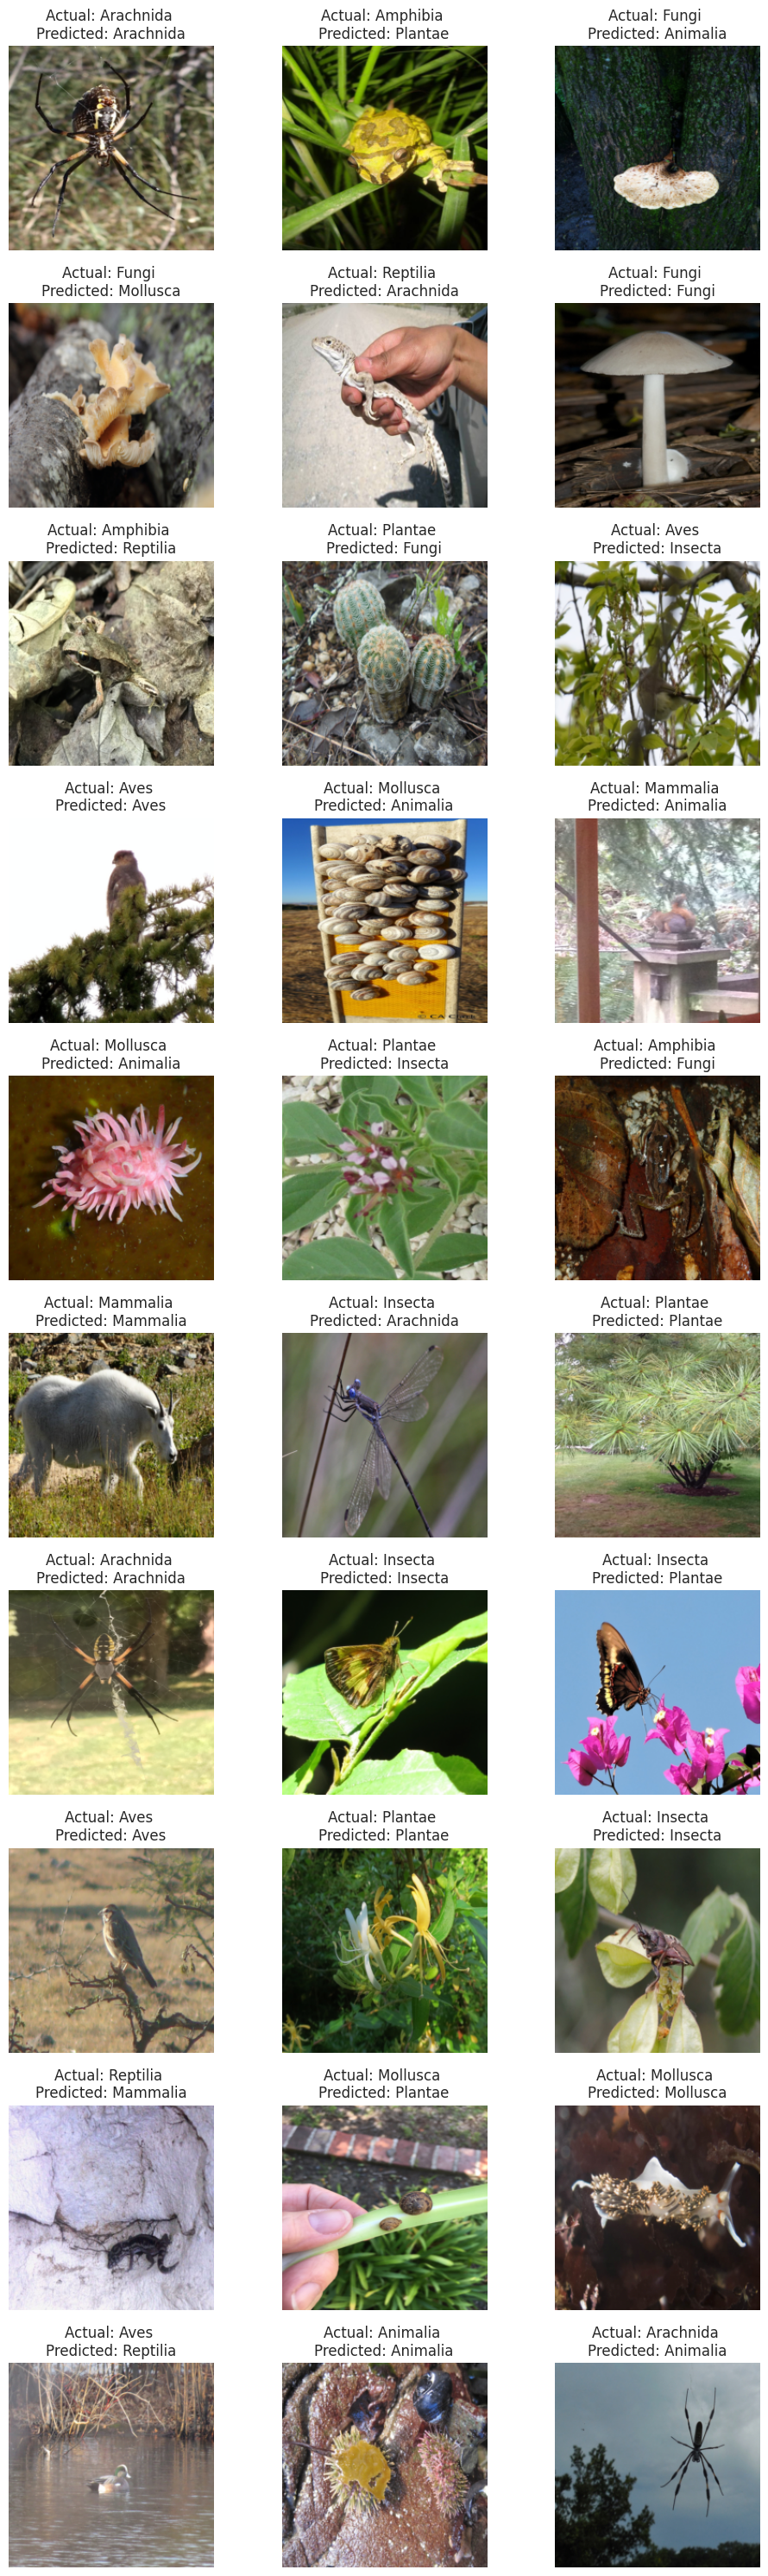

In [ ]:
sweep_id=wandb.sweep(sweep=sweep_config,project="ASSIGN_2_DL")
wandb.agent(sweep_id,show_predictions,count=1)


In [ ]:
wandb.finish()